# Forecasting House Price Index

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/FinanceOps) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmlHaWuVxIA0pKL1yjryR0Z)

## Introduction

In a [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01C_Theory_of_Long-Term_Stock_Forecasting.ipynb) we developed a theory for long-term forecasting of stock returns. The mathematical formulas were derived directly from the definition of the annualized return, and the model fit the characteristic trends that we often observed in historical stock returns.

In this paper we will use the same ideas to derive formulas for long-term forecasting of a House Price Index (HPI) from a valuation ratio, which is defined as the HPI divided by the median earnings for a broad segment of people.

It makes intuitive sense that house prices ought to follow  people's disposable income, because that income must cover housing and all other living costs. So when housing becomes too expensive, the market forces of supply and demand ought to bring house prices back to some more sustainable equilibrium.

To demonstrate these ideas, we use historical data for USA. The forecasting model fits the historical data quite well. Whether it will actually work for predicting the future change in the House Price Index, depends on how well we can predict the average future growth in personal earnings, and the average future ratio between the HPI and personal earnings.

## Python Imports

This Jupyter Notebook is implemented in Python v. 3.6 and requires various packages for numerical computations and plotting. See the installation instructions in the README-file.

In [12]:
%matplotlib inline

In [13]:
# Imports from Python packages.
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import ttest_rel, ttest_ind
import pandas as pd
import numpy as np
import os

In [14]:
# Imports from FinanceOps.
from data_keys import *
from data import load_usa_cpi, _resample_daily

## Data

We will use the following data:

- House Price Index has data-key HPI and is taken from: "All-Transactions House Price Index for USA." https://fred.stlouisfed.org/series/USSTHPI

- Mortgage rate has data-key MORTGAGE_RATE and is taken from: "30 year mortgage rates for USA."
https://fred.stlouisfed.org/series/MORTGAGE30US

- Personal income or earnings has data-key EARNINGS and is taken from: "Employed full time: Median usual weekly nominal earnings (second quartile): Wage and salary workers: 16 years and over."
https://fred.stlouisfed.org/series/LEU0252881500Q

- Personal income inflation-adjusted has data-key EARNINGS_REAL and is taken from: "Employed full time: Median usual weekly real earnings: Wage and salary workers: 16 years and over."
https://fred.stlouisfed.org/series/LES1252881600Q

If you want to experiment with other data, these links may be useful:

- House Price indices for different regions of USA:
https://fred.stlouisfed.org/release?rid=171

- Mortgage rates for USA:
https://fred.stlouisfed.org/categories/114

- Wages for different segments of people in USA:
https://fred.stlouisfed.org/tags/series?t=full-time%3Bmedian%3Bwages&ob=pv&od=desc

### Data Keys

These are keys used for naming data-columns.

In [15]:
# House Price Index (HPI).
HPI = "HPI"
HPI_REAL = "HPI (Real)"

# Weekly earnings, nominal and real.
EARNINGS = "Earnings"
EARNINGS_REAL = "Earnings (Real)"

# Annual growth in weekly earnings, nominal and real.
EARNINGS_GROWTH = "Earnings Growth"
EARNINGS_GROWTH_REAL = "Earnings Growth (Real)"

# Valuation ratio for HPI / Earnings.
RATIO = "HPI/Earnings"

# Valuation ratio for Mortgage Factor x HPI / Earnings.
RATIO_MF = "MF x HPI/Earnings"

# Annualized Return, nominal and real.
ANN_RETURN = "Ann. Return"
ANN_RETURN_REAL = "Ann. Return (Real)"

# Mortgage rate.
MORTGAGE_RATE = "Mortgage Rate 30-Year"

# Mortgage factor.
MORTGAGE_FACTOR = "Mortgage Factor"

### Function for Loading Data

In [16]:
# Directory where the data-files are located.
data_dir = "data/"

def _load_data(filename, new_name=None):
    """
    Load a CSV-file with comma-separation.
    Dates are in the first column with format MM/DD/YYYY.

    This is a simple wrapper for Pandas.read_csv().

    :param filename: Filename for the data-file.
    :param new_name: (Optional) string with new data-name.
    :return: Pandas DataFrame or Series.
    """

    # Path for the data-file.
    path = path = os.path.join(data_dir, filename)

    # Load data.
    data = pd.read_csv(path,
                       sep=",",
                       index_col=0,
                       parse_dates=True,
                       dayfirst=False)

    # Convert to Series if only one column (equivalent to old squeeze=True behavior)
    if len(data.columns) == 1:
        data = data.iloc[:, 0]

    # Rename data column.
    if new_name is not None:
        data = data.rename(new_name)
    
    return data

### Load Data

In [17]:
# Load Consumer Price Index (CPI).
df_CPI = load_usa_cpi()

/Users/pastil/Dev/Github/FinanceOps/data.py:254: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(path, sep=",", parse_dates=[3], index_col=3)


In [18]:
# Load House Price Index (HPI).
filename = "USA House Price Index.csv"
df_HPI = _load_data(filename=filename, new_name=HPI)

In [19]:
# Load Weekly Earnings (Nominal).
filename = "USA Median Weekly Nominal Earnings.csv"
df_earnings = _load_data(filename=filename, new_name=EARNINGS)

In [20]:
# Load Weekly Earnings (Real).
filename = "USA Median Weekly Real Earnings.csv"
df_earnings_real = _load_data(filename=filename, new_name=EARNINGS_REAL)

In [21]:
# Load Mortgage Rate 30-Year and resample to daily data.
filename = "USA Mortgage Rate 30-Year.csv"
df_mortgage_rate = _load_data(filename=filename, new_name=MORTGAGE_RATE)
df_mortgage_rate /= 100.0
df_mortgage_rate = _resample_daily(df_mortgage_rate)

In [22]:
# Combine the time-series into a single DataFrame.
dfs = [df_HPI, df_earnings, df_earnings_real,
       df_CPI, df_mortgage_rate]
df = pd.concat(dfs, axis=1)
df = df.dropna()

In [23]:
# Inflation-adjusted (real) House Price Index (HPI).
df[HPI_REAL] = df[HPI] / df[CPI]

### Mortgage Factor

The "Mortgage Factor" scales the price of a house, to adjust for the total interest payments. The formula follows from the standard formulas for compounded interest payments (see e.g. [Wikipedia](https://en.wikipedia.org/wiki/Compound_interest#Monthly_amortized_loan_or_mortgage_payments)):

$$
    Mortgage\ Factor = Years \cdot \frac{Mortgage\ Rate}{1 - \frac{1}{(1+Mortgage\ Rate) ^ {Years}}}
$$

For example, if the mortgage rate is 5% and the mortgage runs for 30 years, then the Mortgage Factor is about 1.95, so if a house costs USD 100,000 in cash, then with a 30-year mortgage at 5%, the total cost of the house is USD 195,000. If instead the mortgage rate was 7%, then the Mortgage Factor would be about 2.42 so the total cost of the house would be USD 242,000.

Instead of scaling dollar-prices for houses, we will scale the House Price Index, but the idea is the same; to adjust the index-level with the full cost of buying a house, which depends on the mortgage rates at the time.

(Note that interest payments may be tax-deductible, but that is ignored here.)

In [24]:
# Calculate the Mortgage Factor.
years = 30
df[MORTGAGE_FACTOR] = years * df_mortgage_rate / (1 - 1 / (1 + df_mortgage_rate) ** years)

### Earnings Growth

In [25]:
# Calculate growth in personal earnings (income, wages).
# Assume the data is quarterly.
periods=4
df[EARNINGS_GROWTH] = df[EARNINGS].pct_change(periods=periods)
df[EARNINGS_GROWTH_REAL] = df[EARNINGS_REAL].pct_change(periods=periods)

### Valuation Ratios

We will use two different valuation ratios to gauge whether the House Price Index (HPI) is currently over- or under-valued. The first valuation ratio is simply the HPI divided by the personal earnings or income:

$$
Valuation\ Ratio = \frac{House\ Price\ Index}{Personal\ Earnings} = \frac{HPI}{Earnings}
$$

The other valuation ratio multiplies the HPI with the Mortgage Factor, to try and account for the total cost involved in purchasing a house:

$$
Valuation\ Ratio_{MF} = \frac{Mortgage\ Factor \cdot House\ Price\ Index}{Personal\ Earnings} = \frac{MF \cdot HPI}{Earnings}
$$


In [26]:
# Valuation ratio: HPI / Personal Earnings
df[RATIO] = df[HPI] / df[EARNINGS]

# Valuation ratio: Mortgage Factor x HPI / Personal Earnings
df[RATIO_MF] = df[MORTGAGE_FACTOR] * df[HPI] / df[EARNINGS_REAL]

### Prepare Annualized Returns

Helper-function for calculating the annualized returns on the House Price Index, both nominal and real / inflation-adjusted.

In [27]:
def prepare_ann_returns(df, years):
    """
    Calculate the annualized return on the House Price Index (HPI)
    and add the data-columns to the DataFrame `df` with
    keys ANN_RETURN and ANN_RETURN_REAL.
    
    :param df:
        Pandas DataFrame with columns named HPI and HPI_REAL.
        Assume the data is quarterly.

    :param years:
        Number of years for the annualized returns.

    :return:
        None. The DataFrame `df` is updated.
    """

    # Number of quarters corresponding to the number of years.
    quarters = 4 * years

    # Nominal annualized return for the HPI.
    df[ANN_RETURN] = (df[HPI].shift(-quarters) / df[HPI]) ** (1/years) - 1

    # Real (inflation-adjusted) annualized return for the HPI.
    df[ANN_RETURN_REAL] = (df[HPI_REAL].shift(-quarters) / df[HPI_REAL]) ** (1/years) - 1

## Data Analysis

We will now analyze the data we have loaded. Let us check the first rows of the DataFrame.

In [28]:
df.head()

,HPI,Earnings,Earnings (Real),CPI,Mortgage Rate 30-Year,HPI (Real),Mortgage Factor,Earnings Growth,Earnings Growth (Real),HPI/Earnings,MF x HPI/Earnings
Date,,,,,,,,,,,
1979-01-01,91.38,234.0,335.0,68.3,0.103800,1.337921,3.283688,NaN,NaN,0.390513,0.895712
1979-04-01,94.37,239.0,335.0,70.6,0.104586,1.336686,3.304740,NaN,NaN,0.394854,0.930950
1979-07-01,96.38,240.0,330.0,73.1,0.111086,1.318468,3.480202,NaN,NaN,0.401583,1.016430
1979-10-01,98.29,249.0,326.0,75.2,0.113500,1.307048,3.545937,NaN,NaN,0.394739,1.069111
1980-01-01,100.00,256.0,321.0,77.8,0.128714,1.285347,3.966352,0.094017,-0.041791,0.390625,1.235624


### House Price Index (HPI)

The House Price Index (HPI) measures average price changes of single-family house prices in USA, see the [detailed description](https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index.aspx).

The following plot shows a fairly steady increase in the nominal HPI, except for a peak around year 2007 and a valley around year 2011-12.

<Axes: xlabel='Date'>

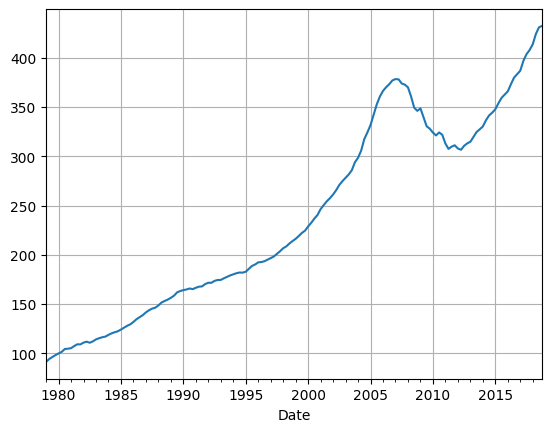

In [29]:
df[HPI].plot(grid=True)

The following plot shows the real or inflation-adjusted HPI, which is more irregular with more extreme peaks and valleys.

<Axes: xlabel='Date'>

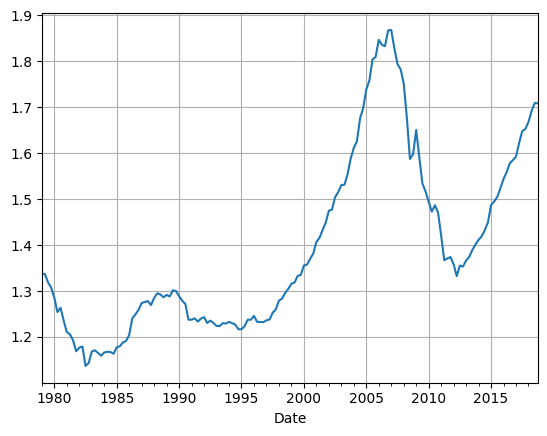

In [30]:
df[HPI_REAL].plot(grid=True)

### Personal Earnings

The following plot shows the median weekly earnings of wage and salary workers in USA, see [detailed description](https://fred.stlouisfed.org/series/LEU0252881500Q). This plot shows the nominal earnings increasing fairly smoothly during this nearly 40-year period, starting at 234 in year 1979 and ending at 876 in 2018.

<Axes: xlabel='Date'>

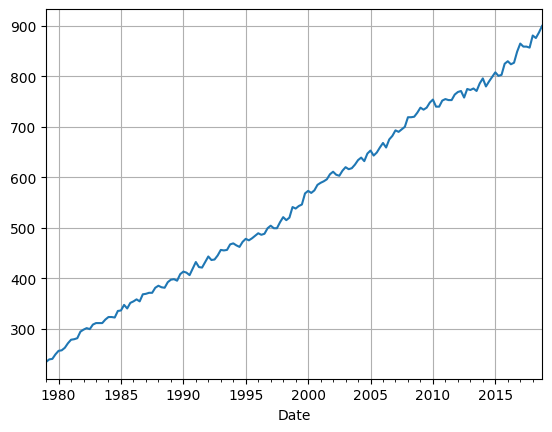

In [31]:
df[EARNINGS].plot(grid=True)

The following plot shows the real or inflation-adjusted earnings, which is much more irregular and only increased from 335 in year 1979 to 351 in year 2018. Although the nominal earnings almost quadrupled in this 40-year period, the inflation-adjusted earnings actually only increased by about 5%, which is only about 0.1% annualized growth.

<Axes: xlabel='Date'>

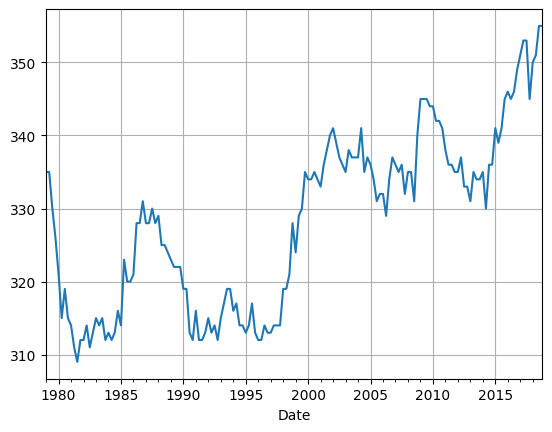

In [32]:
df[EARNINGS_REAL].plot(grid=True)

### Personal Earnings Growth

The following plot shows the annual growth in nominal earnings. The summary statistics show the mean earnings growth was about 3.4% per year.

<Axes: xlabel='Date'>

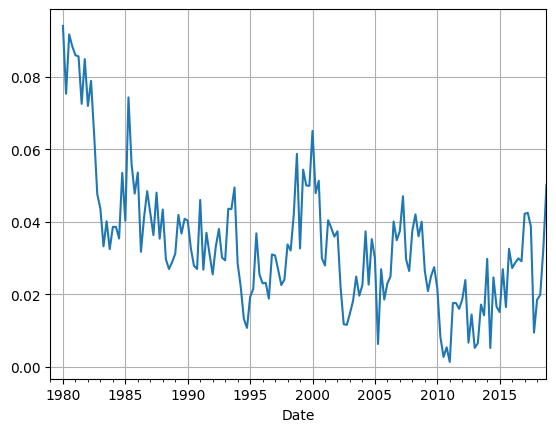

In [33]:
df[EARNINGS_GROWTH].plot(grid=True)

In [34]:
df[EARNINGS_GROWTH].describe()

count    156.000000
mean       0.034167
std        0.018377
min        0.001326
25%        0.022635
50%        0.031098
75%        0.041921
max        0.094017
Name: Earnings Growth, dtype: float64

The following plot shows the annual growth in real or inflation-adjusted earnings. The mean growth was only about 0.15% per year.

<Axes: xlabel='Date'>

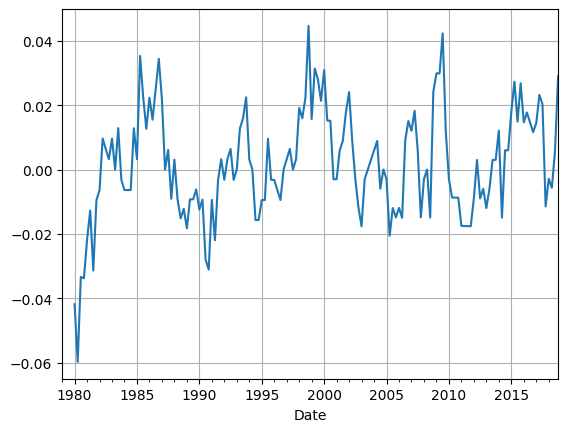

In [35]:
df[EARNINGS_GROWTH_REAL].plot(grid=True)

In [36]:
df[EARNINGS_GROWTH_REAL].describe()

count    156.000000
mean       0.001733
std        0.016654
min       -0.059701
25%       -0.009231
50%        0.000000
75%        0.013259
max        0.044586
Name: Earnings Growth (Real), dtype: float64

### Mortgage Rate and Mortgage Factor

The following plot shows the average 30-year mortgage rate for USA ([source](https://fred.stlouisfed.org/series/MORTGAGE30US)).

<Axes: xlabel='Date'>

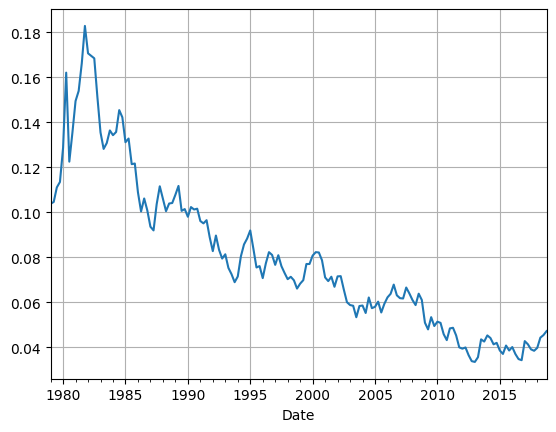

In [37]:
df[MORTGAGE_RATE].plot(grid=True)

The following plot shows the "Mortgage Factor", which can be used to scale the House Price Index to adjust for the total interest payments for a 30-year mortgage. The mathematical formula for calculating the Mortgage Factor was given further above.

<Axes: xlabel='Date'>

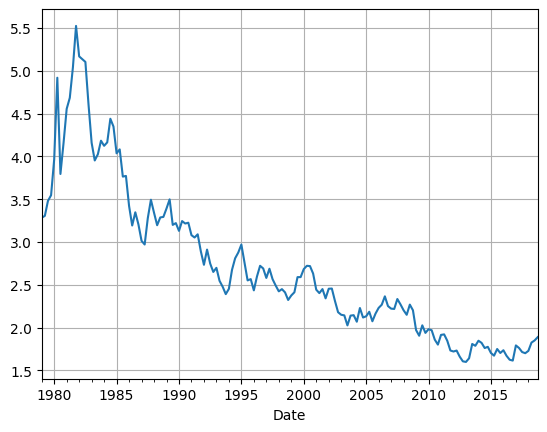

In [38]:
df[MORTGAGE_FACTOR].plot(grid=True)

The two plots above of the mortgage rate and mortgage factor, seem to be nearly identical except for a different scale on the y-axis. If we make a scatter-plot then we see that the relation is almost linear.

<Axes: xlabel='Mortgage Rate 30-Year', ylabel='Mortgage Factor'>

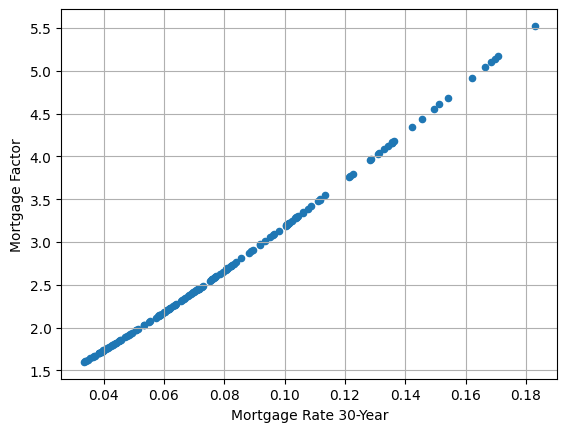

In [39]:
df.plot(kind='scatter', grid=True,
        x=MORTGAGE_RATE, y=MORTGAGE_FACTOR)

### Valuation Ratios

The following plot compares the House Price Index (HPI) to personal earnings, both normalized to start at 1. For the first 20 years between 1979 and 1999, they grew nearly identically. Then between 1999 and 2007, the House Price Index diverged and grew much more than personal earnings. The peak of the HPI was reached in 2006 where the HPI had grown about 44% more than personal earnings. In the following years the HPI fell back to reach nearly the same level as personal earnings in 2012. After that, the HPI started to diverge again and at the end of this time-series in 2018, the HPI had grown 25% more than personal earnings.

<Axes: xlabel='Date'>

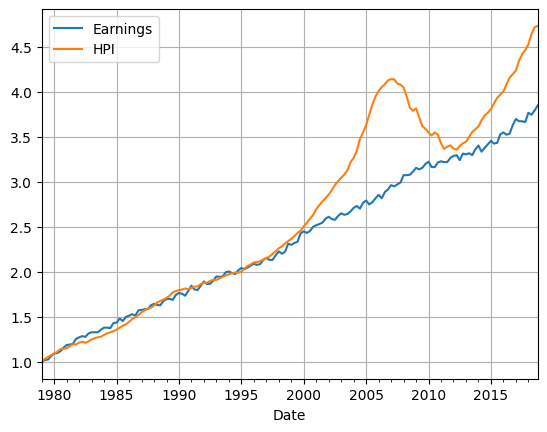

In [40]:
# Compare Earnings and HPI.
# Normalize to start at 1.0
df2 = df[[EARNINGS, HPI]].dropna()
df2 /= df2.values[0]
df2.plot(grid=True)

The following plot shows the valuation ratio $\frac{HPI}{Earnings}$. The statistics show that the median was about 0.40, which is roughly the valuation ratio for the period between 1979 and 1999, where the HPI and personal earnings grew nearly identically. At the peak in 2006, the valuation ratio was above 0.55.

The valuation ratios are unfortunately somewhat abstract and difficult to interpret, because the HPI values are normalized to a value of 100 on January 1st, 1980. It would have been more useful if the HPI values were some measure of dollar-amounts, because the valuation ratios might then reveal why there seems to be an equilibrium in the period between 1979 and 1999, when personal income was a certain fraction of house prices.

<Axes: title={'center': 'HPI / Earnings'}, xlabel='Date'>

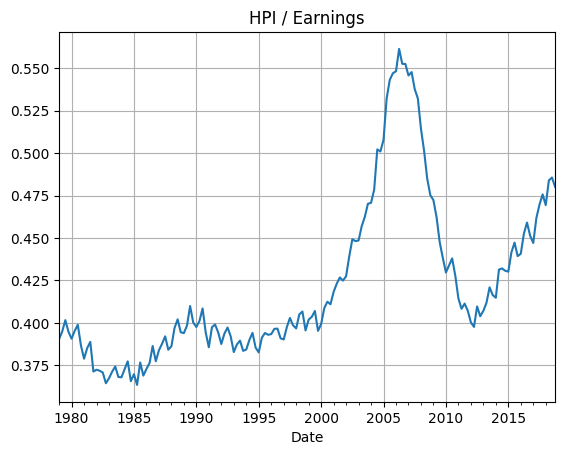

In [41]:
df[RATIO].plot(title="HPI / Earnings", grid=True)

In [42]:
df[RATIO].describe()

count    160.000000
mean       0.421818
std        0.047902
min        0.363401
25%        0.390434
50%        0.402467
75%        0.447116
max        0.561426
Name: HPI/Earnings, dtype: float64

The following plot shows the valuation ratio $\frac{MF \cdot HPI}{Earnings}$, which scales the House Price Index by the Mortgage Factor, so as to take into account the current level of mortgage rates and the total interest payments required for purchasing a house. The statistics show that the median was around 1.7 and it peaked above 2.5 in 2006-2007.

As with the simpler valuation ratio above, this is also somewhat abstract and difficult to interpret, because the HPI is normalized to start at 100 in year 1980.

<Axes: title={'center': 'MF x HPI / Earnings'}, xlabel='Date'>

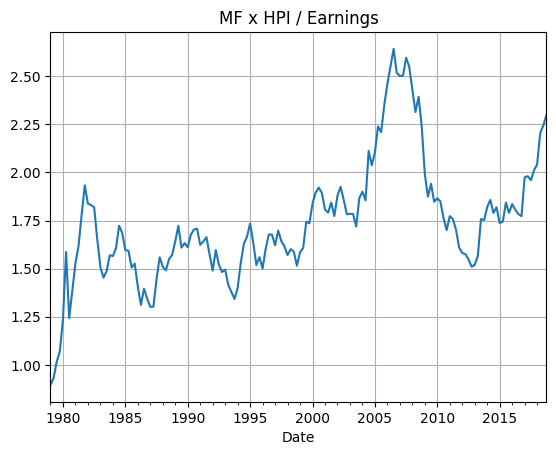

In [43]:
df[RATIO_MF].plot(title="MF x HPI / Earnings", grid=True)

In [44]:
df[RATIO_MF].describe()

count    160.000000
mean       1.738685
std        0.314817
min        0.895712
25%        1.563832
50%        1.701015
75%        1.855172
max        2.641518
Name: MF x HPI/Earnings, dtype: float64

### HPI Annualized Returns

The following plot shows the annualized returns on the House Price Index for all 10-year periods. The highest return was nearly 7% per year for the period starting in 1996-7 and ending 10 years later in 2006-7. The lowest return was nearly 0% per year for the period starting in 2006 and ending 10 years later in 2016. Note that these are nominal returns.

In [45]:
# Update the DataFrame with annualized returns.
prepare_ann_returns(df=df, years=10)

<Axes: title={'center': 'HPI Annualized Returns (Nominal)'}, xlabel='Date'>

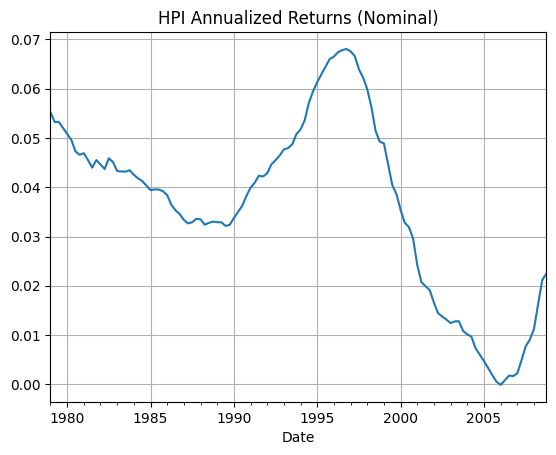

In [46]:
title = "HPI Annualized Returns (Nominal)"
df[ANN_RETURN].dropna().plot(title=title, grid=True)

The following plot shows the real or inflation-adjusted returns on the HPI for all 10-year periods. It shows the same tendencies as the above plot for nominal returns. But the highest return is now only about 4% for the 10-year period between 1996-2006, and the lowest return is now a loss of nearly -2% per year between 2006-2016.

<Axes: title={'center': 'HPI Annualized Returns (Real)'}, xlabel='Date'>

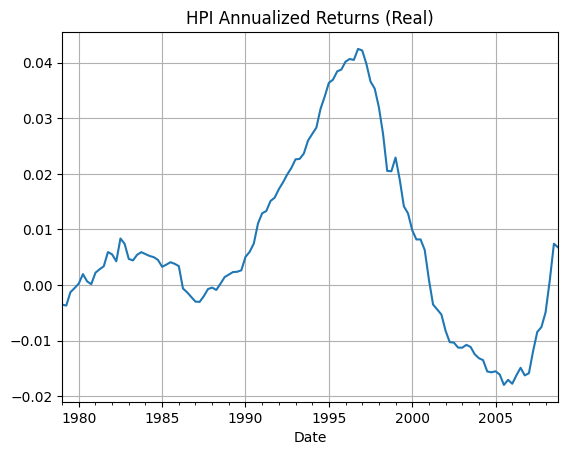

In [47]:
title = "HPI Annualized Returns (Real)"
df[ANN_RETURN_REAL].dropna().plot(title=title, grid=True)

### HPI Valuation Ratio vs. Annualized Returns

We will now study how the valuation ratios are related to the annualized returns. First we need a function for making the scatter-plots.

In [48]:
def plot_valuation_vs_returns(use_mortgage_factor=False,
                              use_real_returns=False):
    """
    Make a scatter-plot with the Valuation Ratio on the x-axis
    and the Annualized Returns on the y-axis.
    
    :param use_mortgage_factor: Boolean whether to use the
                                Mortgage Factor in the Val. Ratio.
    :param use_real_returns: Boolean whether to use Real (True)
                             or Nominal (False) ann. returns.
    :return: Matplotlib Axes.
    """

    # Use Mortgage Factor?
    if use_mortgage_factor:
        x_key = RATIO_MF
    else:
        x_key = RATIO

    # Use Real Returns?
    if use_real_returns:
        y_key = ANN_RETURN_REAL
    else:
        y_key = ANN_RETURN
    
    # Create a figure.
    # Necessary because of a bug in either Pandas or Jupyter?
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211)

    # Create the plot.
    axes = df.plot(kind='scatter', x=x_key, y=y_key,
                   c=MORTGAGE_RATE, cmap='rainbow',
                   grid=True, ax=ax)
    
    # Convert y-ticks to percentages.
    formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
    ax.yaxis.set_major_formatter(formatter)

    return axes

In [49]:
# Update the DataFrame with annualized returns.
prepare_ann_returns(df=df, years=10)

The following scatter-plot shows the valuation ratios $\frac{HPI}{Earnings}$ on the x-axis, versus the 10-year (nominal) annualized returns for the HPI on the y-axis. Apart from the big cluster of dots, there is a characteristic downwards sloping trend that resembles the sloping trends we saw for stock returns in the [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01C_Theory_of_Long-Term_Stock_Forecasting.ipynb).

<Axes: xlabel='HPI/Earnings', ylabel='Ann. Return'>

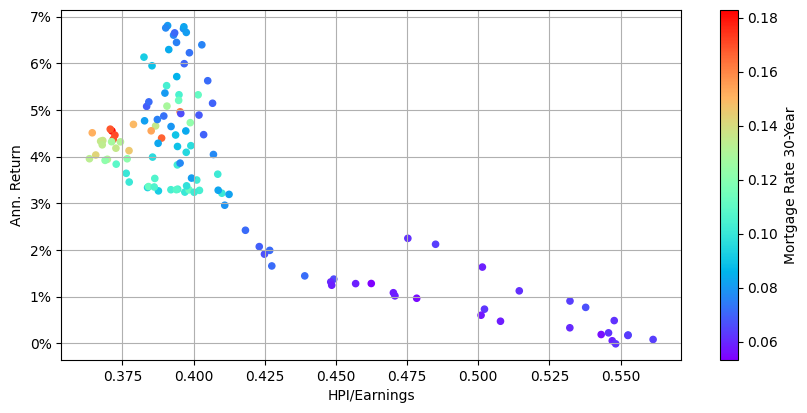

In [50]:
plot_valuation_vs_returns(use_mortgage_factor=False,
                          use_real_returns=False)

## Mathematical Forecasting Model

We saw above that there seems to be a relation between the valuation ratio $\frac{HPI}{Earnings}$ and the annualized return on the HPI. We will now model this relation.

Let us first define the annualized return on the HPI between time-step $t$ and $t + Years$:

$$
    Ann.\ Return_t = \left( \frac{HPI_{t+Years}}{HPI_t} \right) ^ {1/Years} - 1
$$

We want to somehow predict the future annualized return using a valuation ratio such as $\frac{HPI_t}{Earnings_t}$. In order to do this, we will rewrite the above definition of annualized return using a simple mathematical trick, which says that some variable $x$ is equal to $x \cdot y / y$ provided $y \neq 0$. The above definition of annualized return is therefore equivalent to the following:

$$
Ann.\ Return_t = \left( \frac{HPI_{t+Years} \cdot \frac{Earnings_{t+Years}}{Earnings_{t+Years}}}{HPI_t \cdot \frac{Earnings_{t}}{Earnings_{t}}} \right) ^ {1/Years} - 1
= \left( \frac{\frac{HPI_{t+Years}}{Earnings_{t+Years}} \cdot \frac{Earnings_{t+Years}}{Earnings_{t}}}{\frac{HPI_t}{Earnings_{t}}} \right) ^ {1/Years} - 1
$$

This has transformed the definition of annualized return from being defined solely in terms of the change in the House Price Index (HPI), to being defined in terms of the change in valuation ratio $\frac{HPI}{Earnings}$ as well as the growth in personal earnings.

The valuation ratio $\frac{HPI_t}{Earnings_t}$ is known at time-step $t$, but the future valuation ratio and earnings growth for time-step $t + Years$ are both unknown so they are modelled as stochastic variables. We will therefore forecast the mean and standard deviation of the annualized return.

### Forecasted Mean

Using the properties of the expectation operator, we get the following formula for calculating the mean annualized return using the known valuation ratio $\frac{HPI_t}{Earnings_{t}}$ at time-step $t$ and some parameter $a$:

$$
E[Ann.\ Return_t] = \frac{ a }{ \left( \frac{HPI_t}{Earnings_{t}} \right) ^ {1/Years}} - 1
$$

where:

$$
a = E \left[ \left( \frac{HPI_{t+Years}}{Earnings_{t+Years}} \cdot
\frac{Earnings_{t+Years}}{Earnings_{t}} \right) ^ {1/Years} \right]
$$

The above follows directly from the definition of the annualized return. We can simplify this if we assume the stochastic variables for the valuation ratio and earnings growth are independent of each other, and independent over time. We can then estimate the parameter $a$ from the mean valuation ratio and the mean annual earnings growth:

$$
a \simeq E \left[ \left( \frac{HPI}{Earnings} \right) ^ {1/Years} \right] \cdot E[ Earnings\ Growth + 1]
$$

### Forecasted Standard Deviation

Using the mathematical properties for the standard deviation, we get the following formula for calculating the standard deviation of the annualized return, using the known valuation ratio $\frac{HPI_t}{Earnings_t}$ at time-step $t$ and some parameter $b$:

$$
Std[Ann.\ Return_t] = \frac{ b }{ \left( \frac{HPI_t}{Earnings_{t}} \right) ^ {1/Years}}
$$

where

$$
b = Std \left[ \left( \frac{HPI_{t+Years}}{Earnings_{t+Years}} \cdot \frac{Earnings_{t+Years}}{Earnings_{t}} \right) ^ {1/Years} \right]
$$

The above follows directly from the definition of the annualized return. We would again like to simplify this expression and be able to calculate the parameter $b$ from the standard deviation of the valuation ratios and earnings growth separately. But even if we assume they are independent, the closed-form formula for the standard deviation is still quite complicated. 

The [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01C_Theory_of_Long-Term_Stock_Forecasting.ipynb) on stock forecasting used Monte Carlo simulation of the historical data for estimating the parameter $b$. This was quite simple to implement, but the estimated parameter $b$ might not have been so precise.

Here we will use a simpler method, which estimates the parameter $b$ more directly from the historical valuation ratios and annual earnings growth. The formula is almost identical to the definition of $b$ above, except that we use single-year earnings growth instead of multi-year earnings growth that has been annualized. The formula for estimating $b$ is:

$$
b \simeq Std \left[ \left( \frac{HPI_t}{Earnings_t} \right) ^ {1/Years} \cdot (Earnings\ Growth_t + 1) \right]
$$

### Variations

The valuation ratio $\frac{MF \cdot HPI}{Earnings}$ can be used instead of $\frac{HPI}{Earnings}$ simply by exchanging it in the formulas above for $E[Ann.\ Return]$, $Std[Ann.\ Return]$, and parameters $a$ and $b$.

When using real or inflation-adjusted returns instead of nominal returns, we use the real returns when making the scatter-plots, and we use the real earnings growth in the formulas for calculating the parameters $a$ and $b$; but we still use the normal valuation ratios that haven't been adjusted for inflation.

### Implementation

This class implements the mathematical model we developed above.

In [51]:
class ForecastModel:
    """
    Mathematical model used to forecast long-term returns on
    a House Price Index (HPI) using a valuation ratio such
    as HPI / Personal Earnings.
    """

    def __init__(self, df, years,
                 use_mortgage_factor=False,
                 use_real_returns=False,
                 mean_valuation_ratio=None,
                 mean_earnings_growth=None):
        """
        Create a new model and fit it with the given data.

        :param df:
            Pandas DataFrame with required data.

        :param years:
            Number of years to forecast.

        :param use_mortgage_factor:
            Boolean for which valuation ratio to use:
            HPI/Earnings (False) or MF * HPI/Earnings (True).

        :param use_real_returns:
            Boolean whether to use nominal returns (False) or
            real / inflation-adjusted returns (True). Also
            toggles between real and nominal earnings growth.
            
        :param mean_valuation_ratio:
            (Optional) Use this mean valuation ratio instead
            of the mean from the data in `df`.

        :param mean_earnings_growth:
            (Optional) Use this mean earnings growth instead
            of the mean from the data in `df`.
        """

        # Copy args to self.
        self.years = years

        # Use real or nominal returns and earnings growth?
        if use_real_returns:
            # Keys to use real data from the DataFrame.
            ann_return = ANN_RETURN_REAL
            earnings_growth = EARNINGS_GROWTH_REAL
        else:
            # Keys to use nominal data from the DataFrame.
            ann_return = ANN_RETURN
            earnings_growth = EARNINGS_GROWTH
        
        # Use the Mortgage Factor in the valuation ratio?
        if use_mortgage_factor:
            # Key to use valuation ratio: MF * HPI/Earnings
            ratio = RATIO_MF
        else:
            # Key to use valuation ratio: HPI/Earnings
            ratio = RATIO

        # Optional override of the mean valuation ratio.
        if mean_valuation_ratio is None:
            # Use mean valuation ratio from the supplied data.
            mean_valuation_ratio = np.mean(df[ratio] ** (1.0/years))
        else:
            # Override the mean valuation ratio.
            # Note: Due to Jensen's Inequality, this is not
            # identical to mean(df[ratio] ** (1.0/years)) even
            # if mean_valuation_ratio == mean(df[ratio]).
            mean_valuation_ratio = mean_valuation_ratio ** (1.0/years)

        # Use mean earnings growth from the supplied data?
        if mean_earnings_growth is None:
            mean_earnings_growth = np.mean(df[earnings_growth])

        # Add 1.0 to the mean earnings growth.
        mean_earnings_growth += 1.0

        # Calculate the `a` parameter for the mean ann.return.
        self.a = mean_valuation_ratio * mean_earnings_growth

        # Calculate the `b` parameter for the std.dev. ann.return.
        # This is an estimate. Another way of estimating it would be
        # using Monte Carlo simulation.
        self.b = np.std(df[ratio] ** (1/years) * (1 + df[earnings_growth]))

    def forecast(self, ratio_t):
        """
        Use the fitted model to forecast the mean and std.dev.
        for the future HPI returns.
        
        :param ratio_t: Array with different valuation ratios at start-time t.
        :return: Two arrays with mean and std.ann. for the ann. returns
                 for each of the ratio_t values.
        """

        # Annualized ratio_t which is used in both formulas.
        ratio_ann = ratio_t ** (1/self.years)

        # Forecast the mean and std.dev. for the ann. returns
        # for the different choices of valuation ratios.
        mean = self.a / ratio_ann - 1.0
        std = self.b / ratio_ann

        return mean, std
    
    def _ttest(self, err_forecast, err_baseline):
        """
        Perform a t-test on the residual errors of the
        forecasting model and the baseline to assess whether
        their means are equal.
        
        When the resulting p_value is close to zero, the means
        are unlikely to be equal.
        
        :param err_forecast:
            Residual errors for the forecasting model.

        :param err_baseline:
            Residual errors for the baseline.

        :return:
            p_value
        """
        
        if True:
            # Paired t-test.
            t_value, p_value = ttest_rel(a=err_forecast, b=err_baseline)
        else:
            # Un-paired / independent t-test.
            t_value, p_value = ttest_ind(a=err_forecast, b=err_baseline, equal_var=False)

        return p_value

    def MAE(self, ratio_t, ann_rets):
        """
        Calculates the Mean Absolute Error (MAE) between the
        model's forecasted mean and the observed annualized returns.
        
        Also calculates the MAE between the baseline and the
        observed annualized returns.
        
        Also calculates the p-value that the forecasted and
        baseline MAE values are equal.
        
        :param ratio_t:
            Array with different valuation ratios at start-time t.
            
        :param ann_rets:
            Array with the corresponding annualized returns.

        :return:
            mae_forecast: MAE between model's forecast and actual returns.
            mae_baseline: MAE between baseline and actual returns.
            p_value: p-value whether the two MAE values are equal.
        """

        # Forecast the mean and std.dev. for the HPI returns,
        # from the historical valuation ratios.
        mean_forecast, std_forecast = self.forecast(ratio_t=ratio_t)

        # Errors between observed data and forecasting model.
        err_forecast = np.abs(ann_rets - mean_forecast)
        
        # Baseline errors between observed data and its mean.
        err_baseline = np.abs(ann_rets - np.mean(ann_rets))
        
        # Mean Absolute Errors (MAE).
        mae_forecast = np.mean(err_forecast)
        mae_baseline = np.mean(err_baseline)
        
        # Hypothesis test whether the two MAE values are equal.
        p_value = self._ttest(err_forecast=err_forecast,
                              err_baseline=err_baseline)

        return mae_forecast, mae_baseline, p_value
    
    def R_squared(self, ratio_t, ann_rets):
        """
        Calculate the Coefficient of Determination R^2 for
        measuring the Goodness of Fit between the forecasted
        mean and the observed annualized returns.

        An R^2 value of 1 means there is a perfect fit and
        the forecasting model explains all of the variance
        in the data. An R^2 value of zero means the forecasting
        model does not explain any of the variance in the data.
        
        Note that because the forecasting model is non-linear,
        the R^2 can become negative if the model fits poorly
        on data with a large variance.

        :param ratio_t:
            Array with different valuation ratios at start-time t.
            
        :param ann_rets:
            Array with the corresponding annualized returns.

        :return:
            R^2 value.
        """

        # Forecast the mean and std.dev. for the HPI returns,
        # from the historical valuation ratios.
        mean_forecast, std_forecast = self.forecast(ratio_t=ratio_t)

        # Errors between observed data and forecasting model.
        err_forecast = (ann_rets - mean_forecast) ** 2
        
        # Baseline errors between observed data and its mean.
        err_baseline = (ann_rets - np.mean(ann_rets)) ** 2
        
        # Sum of Squared Errors (SSE) for the forecasting model.
        sse = np.sum(err_forecast)
        
        # Sum of Squared Errors (SST) for the baseline.
        sst = np.sum(err_baseline)

        # The R^2 value.
        R_squared = 1.0 - sse / sst
        
        return R_squared

## Print Statistics

This helper-function prints statistics for how well the forecasting model fits the historical data.

In [52]:
def print_statistics(model, ratio_t, ann_rets):
    """
    Calculate and print the Goodness of Fit statistics
    for a model's forecast compared to the baseline.

    The p-value results from a paired t-test whether
    the values are equal. A p-value close to zero means
    that the values are unlikely to be equal.

    :param model:
        Instance of the ForecastModel class.

    :param ratio_t:
        Array with different valuation ratios at start-time.

    :param ann_rets:
        Array with the corresponding annualized returns.
    """
    
    # Print header.
    print("\tForecast\tBaseline\tp-value")
    print("=================================================")

    # Mean Absolute Error (MAE).
    mae_forecast, mae_baseline, p_value = model.MAE(ratio_t=ratio_t,
                                                    ann_rets=ann_rets)
    msg = "MAE:\t{0:.1%}\t\t{1:.1%}\t\t{2:.2e}"
    msg = msg.format(mae_forecast, mae_baseline, p_value)
    print(msg)

    # R^2.
    R_squared = model.R_squared(ratio_t=ratio_t,
                                ann_rets=ann_rets)
    msg = "R^2:\t{0:.2f}"
    msg = msg.format(R_squared)
    print(msg)

## Plotting Function

This is the helper-function for plotting the historical annualized returns and overlay them with the mean and standard deviation of the forecasting model.

In [53]:
def plot(df, years,
         use_mortgage_factor=False,
         use_real_returns=False,
         mean_valuation_ratio=None,
         mean_earnings_growth=None):
    """
    Make a scatter-plot with the historical data for the
    valuation ratio and annualized returns. Overlay this plot
    with the forecasting model's mean and standard deviation.
    
    :param df:
        Pandas DataFrame with required data.

    :param years:
        Number of years to forecast.

    :param use_mortgage_factor:
        Boolean for which valuation ratio to use:
        HPI/Earnings (False) or MF * HPI/Earnings (True).

    :param use_real_returns:
        Boolean whether to use nominal returns (False) or
        real / inflation-adjusted returns (True). Also
        toggles between real and nominal earnings growth.

    :param mean_valuation_ratio:
        (Optional) Use this mean valuation ratio instead
        of the mean from the data in `df`.

    :param mean_earnings_growth:
        (Optional) Use this mean earnings growth instead
        of the mean from the data in `df`.
    """
    
    # Update the DataFrame with annualized returns.
    prepare_ann_returns(df=df, years=years)

    # Create the forecasting model and fit with historical data.
    model = ForecastModel(df=df, years=years,
                          use_mortgage_factor=use_mortgage_factor,
                          use_real_returns=use_real_returns,
                          mean_valuation_ratio=mean_valuation_ratio,
                          mean_earnings_growth=mean_earnings_growth)

    # Scatter-plot of valuation ratios vs. ann. returns.
    ax = plot_valuation_vs_returns(use_mortgage_factor=use_mortgage_factor,
                                   use_real_returns=use_real_returns)

    # Use real or nominal annualized returns?
    if use_real_returns:
        # Use real / inflation-adjusted ann. returns.
        title_ann_ret = "Ann Return Real"
        ann_ret = ANN_RETURN_REAL
    else:
        # Use nominal ann. returns.
        title_ann_ret = "Ann Return"
        ann_ret = ANN_RETURN
    
    # Use the Mortgage Factor in the valuation ratio?
    if use_mortgage_factor:
        # Valuation ratio is: MF * HPI/Earnings
        title_ratio = "(MF $\cdot$ HPI/Earnings)"
        ratio = RATIO_MF
    else:
        # Valuation ratio is: HPI/Earnings
        title_ratio = "(HPI/Earnings)"
        ratio = RATIO

    # Create array of evenly spread valuation ratios.
    # This is used for the x-axis when plotting the
    # curves of the forecasting model.
    ratio_t = np.linspace(start=df[ratio].min(),
                          stop=df[ratio].max(), num=100)

    # Use the forecasting model to calculate the
    # mean and std.dev. for the annualized returns
    # that correspond to the evenly spread valuation ratios.
    mean, std = model.forecast(ratio_t=ratio_t)

    # Plot the forecasting model's mean ann.return.
    ax.plot(ratio_t, mean, color="black", label="Forecast Mean")

    # Plot one standard deviation around the mean.
    color = "green"
    alpha = 0.3
    # Plot lines below and above mean.
    ax.plot(ratio_t, mean-std, color=color,
            label="Forecast Mean $\pm$ 1 Std.Dev.")
    ax.plot(ratio_t, mean+std, color=color)
    # Fill the areas.
    ax.fill_between(ratio_t, mean+std, mean-std,
                    color=color, edgecolor=color, alpha=alpha)

    # Plot two standard deviations around the mean.
    color = "red"
    alpha = 0.1
    # Plot lines below and above mean.
    ax.plot(ratio_t, mean-2*std, color=color,
            label="Forecast Mean $\pm$ 2 Std.Dev.")
    ax.plot(ratio_t, mean+2*std, color=color) 
    # Fill the areas.
    ax.fill_between(ratio_t, mean-std, mean-2*std,
                    color=color, edgecolor=color, alpha=alpha)
    ax.fill_between(ratio_t, mean+std, mean+2*std,
                    color=color, edgecolor=color, alpha=alpha)

    # Plot baseline mean as horizontal dashed line.
    ax.axhline(y=df[ann_ret].mean(), color="black", linestyle="--",
               label="Baseline")

    # Show legend.
    ax.legend()
    
    # Create plot-title.
    # First part of the title.
    msg = "{0}-Year {1} for House Price Index (HPI)"
    title1 = msg.format(years, title_ann_ret)
    # Second part of the title. Formula for mean ann. return.
    msg = "E[{0}] = {1:.2f} / ({2} ^ (1/{3})) - 1"
    title2 = msg.format(title_ann_ret, model.a, title_ratio, years)
    # Third part of the title. Formula for std.dev. ann. return.
    msg = "Std[{0}] = {1:.3f} / ({2} ^ (1/{3}))"
    title3 = msg.format(title_ann_ret, model.b, title_ratio, years)
    # Combine and set the plot-title.
    title = "\n".join([title1, title2, title3])
    ax.set_title(title)

    # Show the plot.
    plt.show()

    # Get the historical valuation ratios and ann. returns.
    df2 = df[[ratio, ann_ret]].dropna()
    
    # Print the Goodness of Fit statistics for how well
    # the forecasting model fits the historical data.
    print_statistics(model=model,
                     ratio_t=df2[ratio],
                     ann_rets=df2[ann_ret])

<>:62: SyntaxWarning: invalid escape sequence '\c'
<>:88: SyntaxWarning: invalid escape sequence '\p'
<>:99: SyntaxWarning: invalid escape sequence '\p'
<>:62: SyntaxWarning: invalid escape sequence '\c'
<>:88: SyntaxWarning: invalid escape sequence '\p'
<>:99: SyntaxWarning: invalid escape sequence '\p'
/var/folders/1x/ykphkxv54clg878qwgm62z740000gn/T/ipykernel_10430/89704060.py:62: SyntaxWarning: invalid escape sequence '\c'
  title_ratio = "(MF $\cdot$ HPI/Earnings)"
/var/folders/1x/ykphkxv54clg878qwgm62z740000gn/T/ipykernel_10430/89704060.py:88: SyntaxWarning: invalid escape sequence '\p'
  label="Forecast Mean $\pm$ 1 Std.Dev.")
/var/folders/1x/ykphkxv54clg878qwgm62z740000gn/T/ipykernel_10430/89704060.py:99: SyntaxWarning: invalid escape sequence '\p'
  label="Forecast Mean $\pm$ 2 Std.Dev.")


## Forecasting 1-Year Returns

Let us now try and fit the forecasting model to historical data, to see if it works when we already know the future valuation ratio and earnings growth.

The following plot shows the basic valuation ratio $\frac{HPI}{Earnings}$ versus 1-year nominal returns on the HPI. As can be seen, the forecasting model has a horrible fit. The Mean Absolute Error (MAE) is 8.4% for the forecasting model, while it is only 2.8% for the baseline, which is just the average 1-year HPI return. The $R^2$ is very negative because the forecasting model is non-linear and it fits the data so badly.

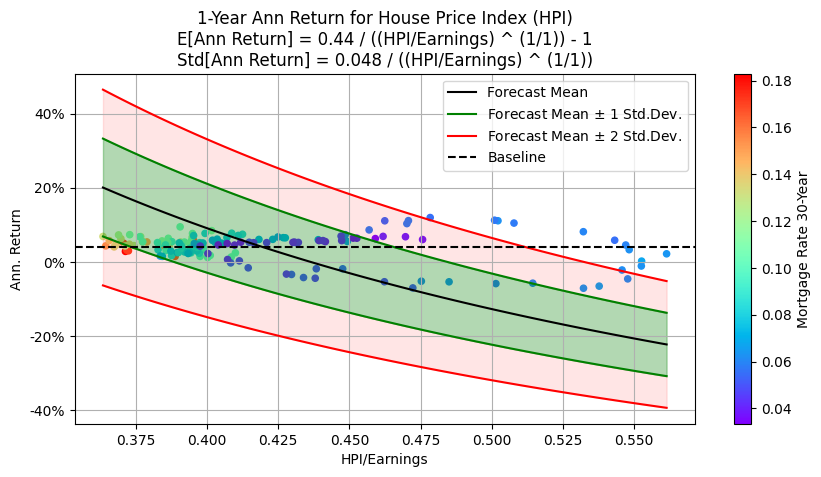

	Forecast	Baseline	p-value
MAE:	8.5%		2.7%		3.49e-23
R^2:	-6.58


In [54]:
plot(df=df, years=1,
     use_mortgage_factor=False,
     use_real_returns=False)

## Forecasting 2-Year Returns

The following plot shows the 2-year annualized returns which still fits very poorly. Note that there seems to be two arcs in the scatter-plot.

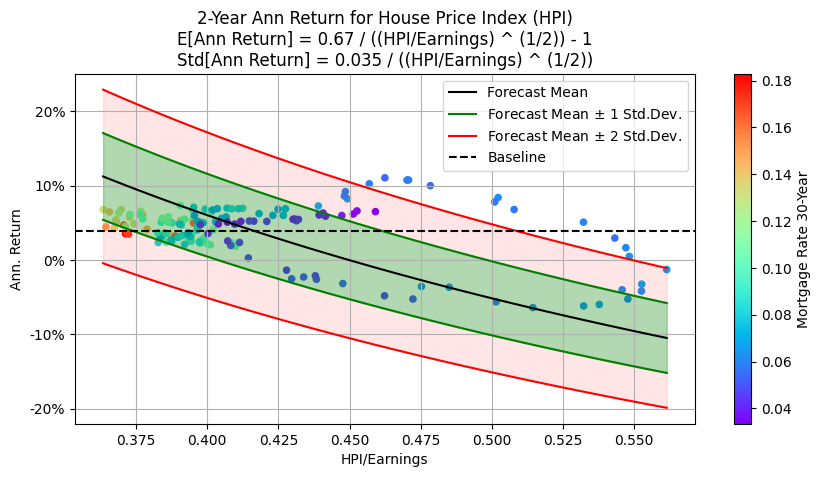

	Forecast	Baseline	p-value
MAE:	4.2%		2.6%		3.44e-07
R^2:	-1.11


In [55]:
plot(df=df, years=2,
     use_mortgage_factor=False,
     use_real_returns=False)

## Forecasting 4-Year Returns

The following plot shows 4-year annualized returns on the HPI, which now starts to be fitted by the forecasting model with $R^2 = 0.38$, although there are still two visible arcs.

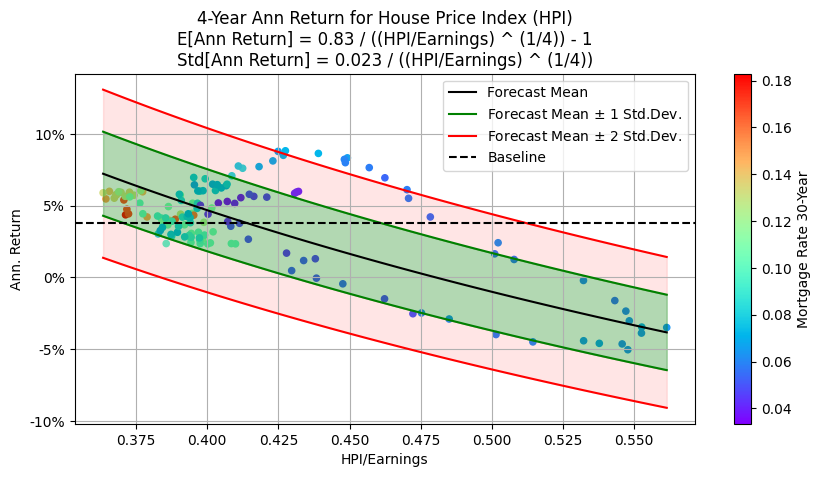

	Forecast	Baseline	p-value
MAE:	2.0%		2.3%		8.40e-02
R^2:	0.37


In [56]:
plot(df=df, years=4,
     use_mortgage_factor=False,
     use_real_returns=False)

## Forecasting 5-Year Returns

For 5-year annualized returns the two arcs start to collapse into one, which improves the forecasting model's fit to having $R^2 = 0.55$.

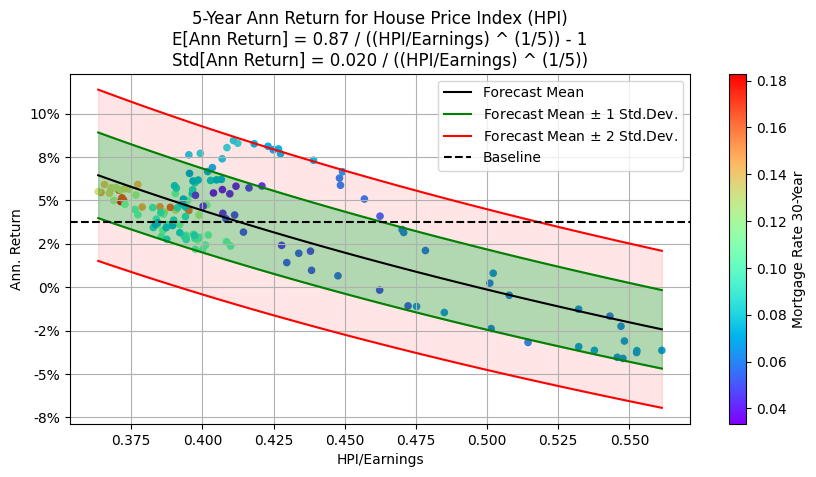

	Forecast	Baseline	p-value
MAE:	1.6%		2.2%		1.16e-04
R^2:	0.55


In [57]:
plot(df=df, years=5,
     use_mortgage_factor=False,
     use_real_returns=False)

## Forecasting 6-Year Returns

For 6-year annualized returns, the fit has improved to having $R^2 = 0.63$.

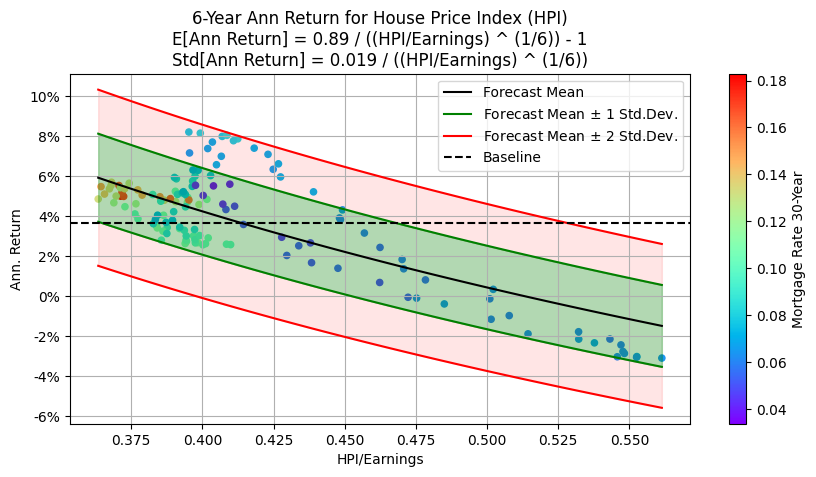

	Forecast	Baseline	p-value
MAE:	1.3%		2.1%		1.32e-07
R^2:	0.63


In [58]:
plot(df=df, years=6,
     use_mortgage_factor=False,
     use_real_returns=False)

## Forecasting 8-Year Returns

For 8-year annualized returns, the fit has improved slightly to having $R^2 = 0.65$.

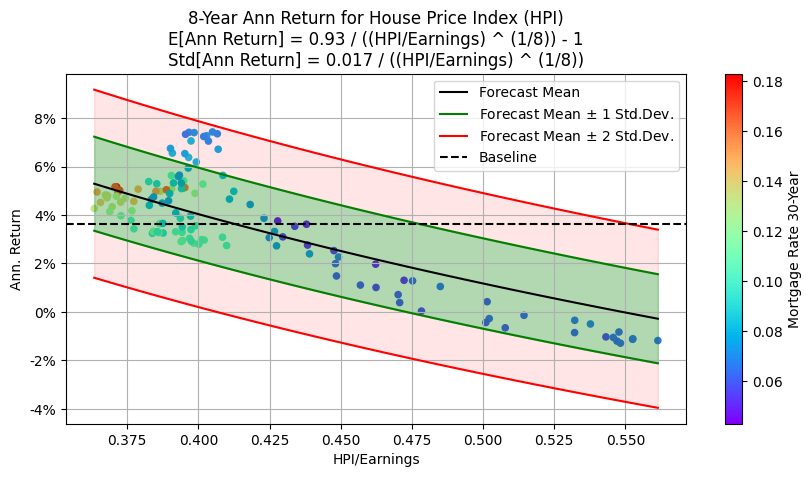

	Forecast	Baseline	p-value
MAE:	1.0%		1.8%		2.04e-10
R^2:	0.65


In [59]:
plot(df=df, years=8,
     use_mortgage_factor=False,
     use_real_returns=False)

## Forecasting 10-Year Returns

For 10-year annualized returns, the fit has become slightly worse with $R^2 = 0.62$.

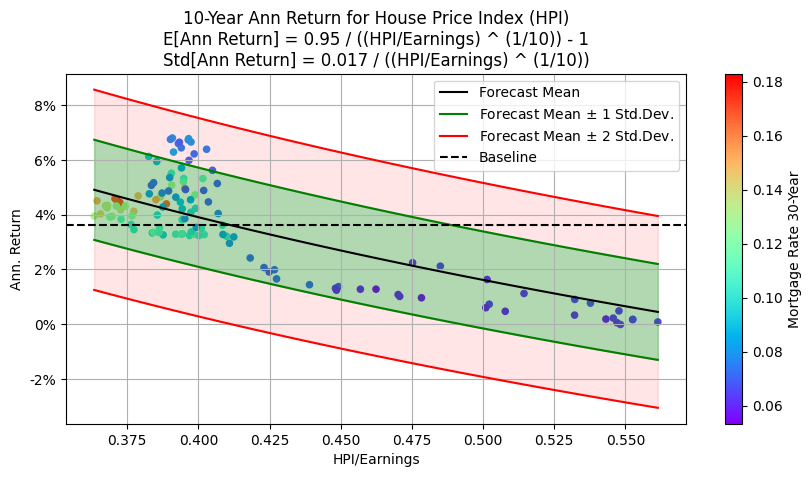

	Forecast	Baseline	p-value
MAE:	0.9%		1.5%		6.74e-10
R^2:	0.62


In [60]:
plot(df=df, years=10,
     use_mortgage_factor=False,
     use_real_returns=False)

## Forecasting 8-Year REAL Returns

The above plots used the nominal returns of the HPI. Let us now try and fit the forecasting model to real or inflation-adjusted returns of the HPI. This also means that the forecasting model uses the real or inflation-adjusted earnings.

As can be seen from the following plot, there is a downwards-sloping trend in the data, which has been captured quite well by the forecasting model. But due to the wider dispersion of the data points, the $R^2$ is only 0.36.

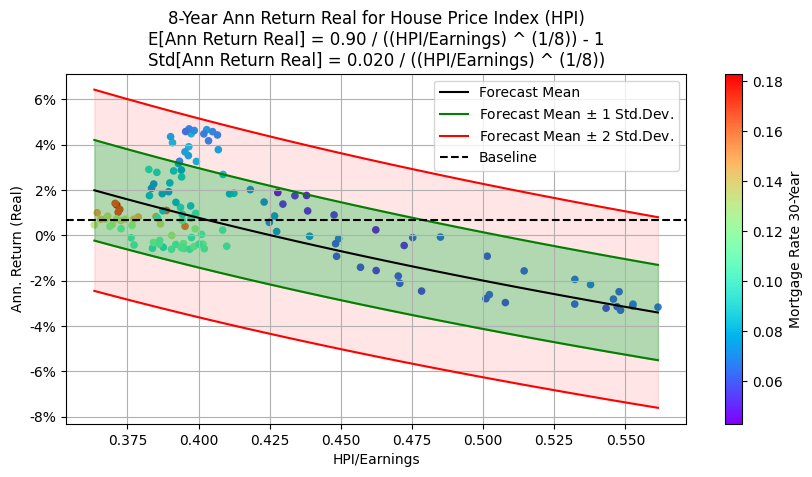

	Forecast	Baseline	p-value
MAE:	1.3%		1.6%		1.30e-02
R^2:	0.36


In [61]:
plot(df=df, years=8,
     use_mortgage_factor=False,
     use_real_returns=True)

## Forecasting with Mortgage Factor

Let us now try and use the valuation ratio which scales the HPI by the Mortgage Factor: $\frac{MF \cdot HPI}{Earnings}$. The following plot shows this valuation ratio versus the nominal 8-year annualized returns on the HPI. There is still a downwards-sloping trend in the data, which is mostly contained by the forecasting model's mean and standard deviation, but the trend in the data is not as clear when using this valuation ratio, so the fit has only $R^2 = 0.20$.

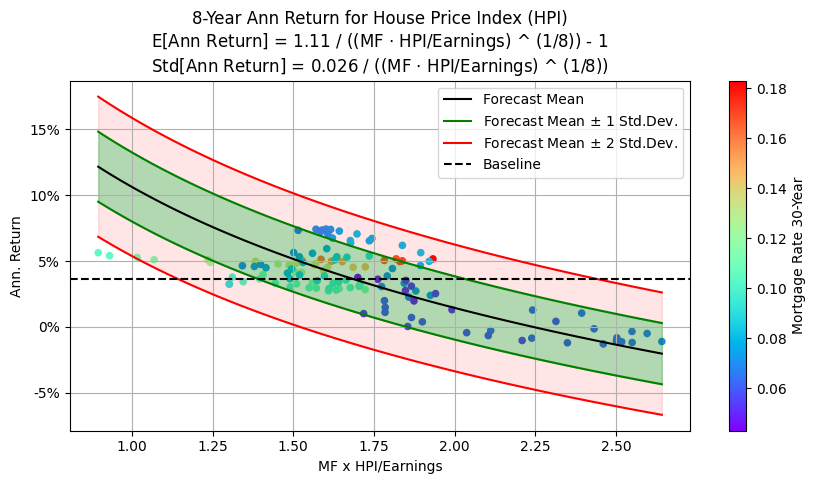

	Forecast	Baseline	p-value
MAE:	1.6%		1.8%		2.35e-01
R^2:	0.20


In [62]:
plot(df=df, years=8,
     use_mortgage_factor=True,
     use_real_returns=False)

## Using Mortgage Factor and Real Returns

The following plot shows the valuation ratio using the Mortgage Factor $\frac{MF \cdot HPI}{Earnings}$ versus the real or inflation-adjusted 8-year annualized returns on the HPI. This has an even worse fit than for nominal returns on the HPI, and now the $R^2$ is negative at -0.61.

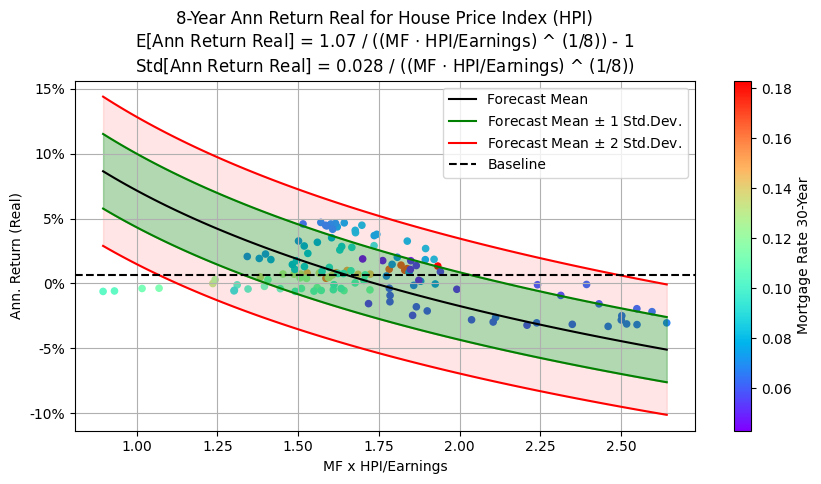

	Forecast	Baseline	p-value
MAE:	2.0%		1.6%		1.03e-02
R^2:	-0.61


In [63]:
plot(df=df, years=8,
     use_mortgage_factor=True,
     use_real_returns=True)

## Equilibrium Valuation Ratio?

The following plot shows the historical valuation ratio $\frac{HPI}{Earnings}$. Between years 1979 and 2000 it was fairly close to 0.4. This was prior to the so-called [subprime mortgage crisis](https://en.wikipedia.org/wiki/Subprime_mortgage_crisis) which caused a bubble in U.S. house prices that peaked around year 2006-2007, and then crashed back to a valuation ratio near 0.4 in 2012, before it started increasing again.

<Axes: xlabel='Date'>

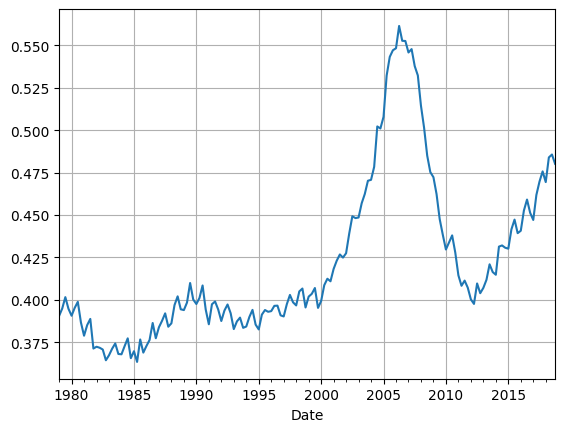

In [64]:
df[RATIO].plot(grid=True)

The following statistics show that between years 1979 and 2000, both the mean and median for the valuation ratio $\frac{HPI}{Earnings}$ was around 0.39. Perhaps this is some form of natural equilibrium between house prices and personal earnings?

In [65]:
df[RATIO]["1979":"2000"].describe()

count    88.000000
mean      0.389274
std       0.012169
min       0.363401
25%       0.382710
50%       0.391642
75%       0.397399
max       0.412439
Name: HPI/Earnings, dtype: float64

Let us try and use the forecasting model with this "equilibrium" valuation ratio of $\frac{HPI}{Earnings} = 0.39$. The following plot shows the nominal 8-year annualized returns on the HPI. The forecasted mean has been moved down slightly, so it fits the tail on the right side of the plot better, but it fits the cluster on the left side of the plot a bit worse, so the overall fit has $R^2 = 0.46$.

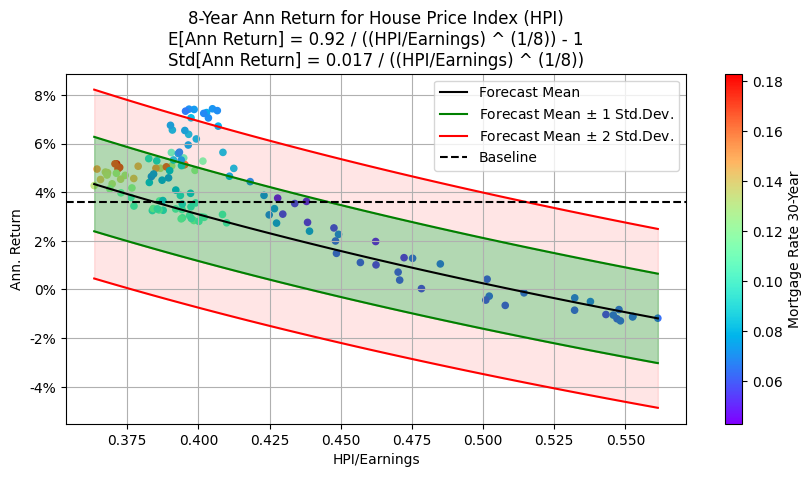

	Forecast	Baseline	p-value
MAE:	1.2%		1.8%		1.30e-05
R^2:	0.45


In [66]:
plot(df=df, years=8,
     use_mortgage_factor=False,
     use_real_returns=False,
     mean_valuation_ratio=0.39,
     mean_earnings_growth=None)

The following plot shows the real or inflation-adjusted 8-year annualized returns on the HPI, with the forecasting model using the "equilibrium" valuation ratio of $\frac{HPI}{Earnings} = 0.39$. But this has moved the forecasted mean too far down, so the line no longer is in the center of the data-points. Combined with the wider dispersion of the data-points, this has caused a poor measure of fit with $R^2 = 0.0$.

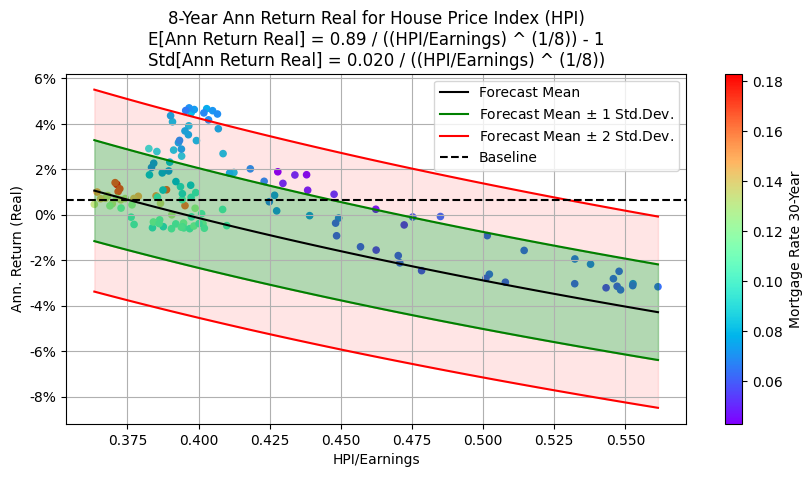

	Forecast	Baseline	p-value
MAE:	1.5%		1.6%		5.67e-01
R^2:	-0.01


In [67]:
plot(df=df, years=8,
     use_mortgage_factor=False,
     use_real_returns=True,
     mean_valuation_ratio=0.39,
     mean_earnings_growth=None)

## Conclusion

We have studied the relation between the House Price Index (HPI) and personal earnings. We developed a mathematical model to forecast the return on the HPI, given the current ratio between the HPI and median earnings for a wide segment of people.

The model was fitted to historical data for USA. The model did not work for shorter periods of only a few years. But starting at 5-year periods, the model fit the historical data quite well. The optimal period seemed to be around 8 years.

The formulas for the mean and standard deviation, for the annualized nominal return for 8-year periods of the HPI, are as follows:

$$
E[Ann\ Return] \simeq \frac{0.92}{\left( \frac{HPI}{Earnings} \right) ^ {1/8}} - 1
$$

$$
Std[Ann\ Return] \simeq \frac{0.017}{\left( \frac{HPI}{Earnings} \right) ^ {1/8}}
$$

To use these formulas you would simply lookup the current data for the HPI and personal earnings (links to the data sources are given above), and use the resulting ratio in these formulas. This gives you an estimate for the mean and standard deviation of the nominal annualized return on the HPI over the next 8 years.

It is possible to change the model's assumptions for the future mean valuation ratio $\frac{HPI}{Earnings}$ and the future growth in personal earnings, if you believe they will be different from the historical data. The accuracy of the model's forecast will depend on how accurately you can predict these two numbers.

It seems reasonable to assume that there is some "equilibrium" between house prices and personal earnings, because people have to pay for the housing along with all other living expenses including food, transportation, health-care, insurance, etc. So a large divergence between house prices and personal income must eventually revert to a more stable level.

We also studied real or inflation-adjusted returns on the HPI, for which the forecasting model fit the historical data reasonably well, but the fit was significantly better for nominal returns on the HPI.

We also considered a variant of the valuation ratio that takes into account the current mortgage rates. This did not work so well on the historical data. The reason is perhaps that house prices already incorportate the current level of mortgage rates, so we might have double-counted the mortgage rates by also incorporating them in the valuation ratio.

## Research Ideas

To my knowledge, there are no academic studies of predicting the long-term returns on house prices as we have done here. This paper has presented the basic idea and methodology, but a lot more research can be done on this subject.

Here are a few more research ideas to get you started:

- Try using data for other regions of USA or other countries. Does the forecasting model work for those?

- Try and find a House Price Index that is based on dollar-amounts instead of a normalized value. Compare the mean or "equilibrium" valuation ratio $\frac{HPI}{Earnings}$ to the typical budgets for a household. Does it explain why the house prices tend to revert to a certain level of personal income?

- Use the average annualized returns e.g. for all 6-10 year periods instead of only 8-year periods. This was done in a [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01E_Forecasting_US_Stock_Indices.ipynb) for stock forecasting, which smoothened the data and greatly improved the fit of the forecasting model.

## License (MIT)

Copyright (c) 2019 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.